## **Real Estate Price Prediction - Phase 1**



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

**Dataset - Russia Real estate.csv**

The dataset has 13 fields.

date - date of publication of the announcement;

time - the time when the ad was published;

geo_lat - Latitude

geo_lon - Longitude

region - Region of Russia. There are 85 subjects in the country in total.

building_type - Facade type. 0 - Other. 1 - Panel. 2 - Monolithic. 3 - Brick. 4 - Blocky. 5 - Wooden

object_type - Apartment type. 1 - Secondary real estate market; 2 - New building;

level - Apartment floor

levels - Number of storeys

rooms - the number of living rooms. If the value is "-1", then it means "studio apartment"

area - the total area of ​​the apartment

kitchen_area - Kitchen area

price - Price. in rubles

In [2]:
data1=pd.read_csv('Russia Real Estate.csv')
df=pd.DataFrame(data1)

Data Preprocessing

In [3]:
df.shape

(28284, 13)

In [4]:
df.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1.0
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1.0
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1.0
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11.0
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1.0


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28284 entries, 0 to 28283
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          28284 non-null  int64  
 1   date           28284 non-null  object 
 2   time           28284 non-null  object 
 3   geo_lat        28284 non-null  float64
 4   geo_lon        28284 non-null  float64
 5   region         28284 non-null  int64  
 6   building_type  28284 non-null  int64  
 7   level          28284 non-null  int64  
 8   levels         28284 non-null  int64  
 9   rooms          28284 non-null  int64  
 10  area           28284 non-null  float64
 11  kitchen_area   28283 non-null  float64
 12  object_type    28283 non-null  float64
dtypes: float64(5), int64(6), object(2)
memory usage: 2.8+ MB


In [6]:
# Constants
MIN_AREA = 20  # Outlier range for floor area
MAX_AREA = 200

MIN_KITCHEN = 6  # Outlier range for kitchen area
MAX_KITCHEN = 30

MIN_PRICE = 1_500_000  # Outlier range for price
MAX_PRICE = 50_000_000

MIN_SQM_PRICE = 75_000  # Outlier range for price per sq. meter
MAX_SQM_PRICE = 250_000

In [7]:
#Fixing negative values
df["rooms"] = df["rooms"].apply(lambda x: 0 if x < 0 else x)
df["price"] = df["price"].abs()

# Drop prices and area outliers
df = df[(df["area"] <= MAX_AREA) & (df["area"] >= MIN_AREA)]
df = df[(df["price"] <= MAX_PRICE) & (df["price"] >= MIN_PRICE)]

# Drop outliers based on price per square meter
# df["sqm_price"] = df["price"] / df["area"]
# df = df[(df["sqm_price"] >= MIN_SQM_PRICE) & (df["sqm_price"] <= MAX_SQM_PRICE)]
# Fix kitchen area
df.loc[
    (df["kitchen_area"] >= MAX_KITCHEN) | (df["area"] <= MIN_AREA), "kitchen_area"
] = 0




Dropping unwanted columns and empty columns (Not required for predicting real estate price) 

In [8]:
df['date'] = pd.to_datetime(df['date'])
# Replace "date" with numeric features for year and month.
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df.drop(['date', 'time'], axis=1, inplace=True)

# Apartment floor in relation to total number of floors.
df['level_to_levels'] = df['level'] / df['levels']
# Average size of room in the apartment.
df['area_to_rooms'] = (df['area'] / df['rooms']).abs()

In [9]:
df = df[df['region'] == 2661]
df.drop('region', inplace=True, axis=1)

Viewing data after preprocessing

Changed date and time to their corresponding year and month


In [10]:
df.head()

,price,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,level_to_levels,area_to_rooms
0,6050000,59.805808,30.376141,1,8,10,3,82.6,10.8,1.0,2018,2,0.800000,27.533333
7,3600000,59.875526,30.395457,1,2,5,1,31.1,6.0,1.0,2018,3,0.400000,31.100000
36,3200000,59.827465,30.201827,1,7,9,1,31.0,7.0,1.0,2018,4,0.777778,31.000000
47,6500000,59.988334,29.786928,3,3,3,3,89.0,10.0,1.0,2018,4,1.000000,29.666667
54,6300000,59.911622,30.284556,3,5,5,2,99.9,14.5,1.0,2018,4,1.000000,49.950000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1596 entries, 0 to 28278
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            1596 non-null   int64  
 1   geo_lat          1596 non-null   float64
 2   geo_lon          1596 non-null   float64
 3   building_type    1596 non-null   int64  
 4   level            1596 non-null   int64  
 5   levels           1596 non-null   int64  
 6   rooms            1596 non-null   int64  
 7   area             1596 non-null   float64
 8   kitchen_area     1596 non-null   float64
 9   object_type      1596 non-null   float64
 10  year             1596 non-null   int64  
 11  month            1596 non-null   int64  
 12  level_to_levels  1596 non-null   float64
 13  area_to_rooms    1596 non-null   float64
dtypes: float64(7), int64(7)
memory usage: 187.0 KB


In [12]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

Normalizing data

In [13]:
x_train=df.drop(['price'],axis=1)

In [14]:
scaler=MinMaxScaler()
x_norm=scaler.fit_transform(x_train)

In [15]:
df.head()  #data before normalization

,price,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,level_to_levels,area_to_rooms
0,6050000,59.805808,30.376141,1,8,10,3,82.6,10.8,1.0,2018,2,0.800000,27.533333
7,3600000,59.875526,30.395457,1,2,5,1,31.1,6.0,1.0,2018,3,0.400000,31.100000
36,3200000,59.827465,30.201827,1,7,9,1,31.0,7.0,1.0,2018,4,0.777778,31.000000
47,6500000,59.988334,29.786928,3,3,3,3,89.0,10.0,1.0,2018,4,1.000000,29.666667
54,6300000,59.911622,30.284556,3,5,5,2,99.9,14.5,1.0,2018,4,1.000000,49.950000


In [16]:
x_norm  #data after normalization

array([[0.2858427 , 0.78014372, 0.2       , ..., 0.        , 0.792     ,
        0.2487523 ],
       [0.4116325 , 0.7975289 , 0.2       , ..., 0.14285714, 0.376     ,
        0.30496454],
       [0.32491707, 0.62325492, 0.2       , ..., 0.28571429, 0.76888889,
        0.30338849],
       ...,
       [0.63400491, 0.71009755, 0.6       , ..., 1.        , 0.76      ,
        0.3821907 ],
       [0.45750933, 0.72197442, 0.4       , ..., 1.        , 0.376     ,
        0.20987654],
       [0.65272765, 0.68779764, 0.2       , ..., 1.        , 0.48      ,
        0.44523247]])

Data Summarization

In [17]:
df.describe() #elaborates type of data and attributes

,price,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,level_to_levels,area_to_rooms
count,1.546000e+03,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000,1546.0,1546.000000,1546.000000,1546.000000
mean,6.172110e+06,59.929570,30.326978,2.249030,7.093144,13.893273,1.957309,57.872031,11.243338,4.331177,2018.0,8.957309,0.535780,31.663705
std,4.350669e+06,0.092140,0.126528,0.912028,5.438719,7.068751,0.939318,24.811951,4.571625,4.714807,0.0,0.398364,0.284233,8.012611
min,1.500000e+06,59.647383,29.509349,0.000000,1.000000,1.000000,1.000000,20.100000,0.000000,1.000000,2018.0,2.000000,0.038462,11.750000
25%,3.886058e+06,59.860622,30.259680,2.000000,3.000000,9.000000,1.000000,39.425000,8.000000,1.000000,2018.0,9.000000,0.300000,25.666667
50%,5.000000e+06,59.937837,30.332167,2.000000,5.000000,13.000000,2.000000,52.000000,10.500000,1.000000,2018.0,9.000000,0.526316,31.000000
75%,6.996750e+06,60.005860,30.415160,3.000000,10.000000,19.000000,3.000000,68.775000,13.675000,11.000000,2018.0,9.000000,0.777778,37.000000
max,4.760000e+07,60.201623,30.620416,5.000000,26.000000,27.000000,7.000000,189.600000,28.500000,11.000000,2018.0,9.000000,1.000000,75.200000


Data Visualization

Correlation Heatmap

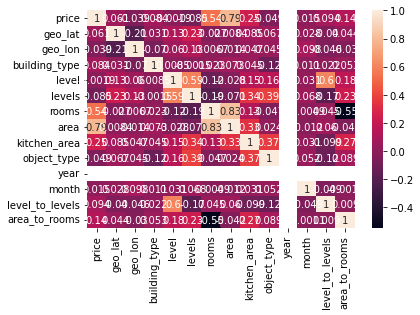

In [18]:
sns.heatmap(df.corr(),annot=True)

Pairplots

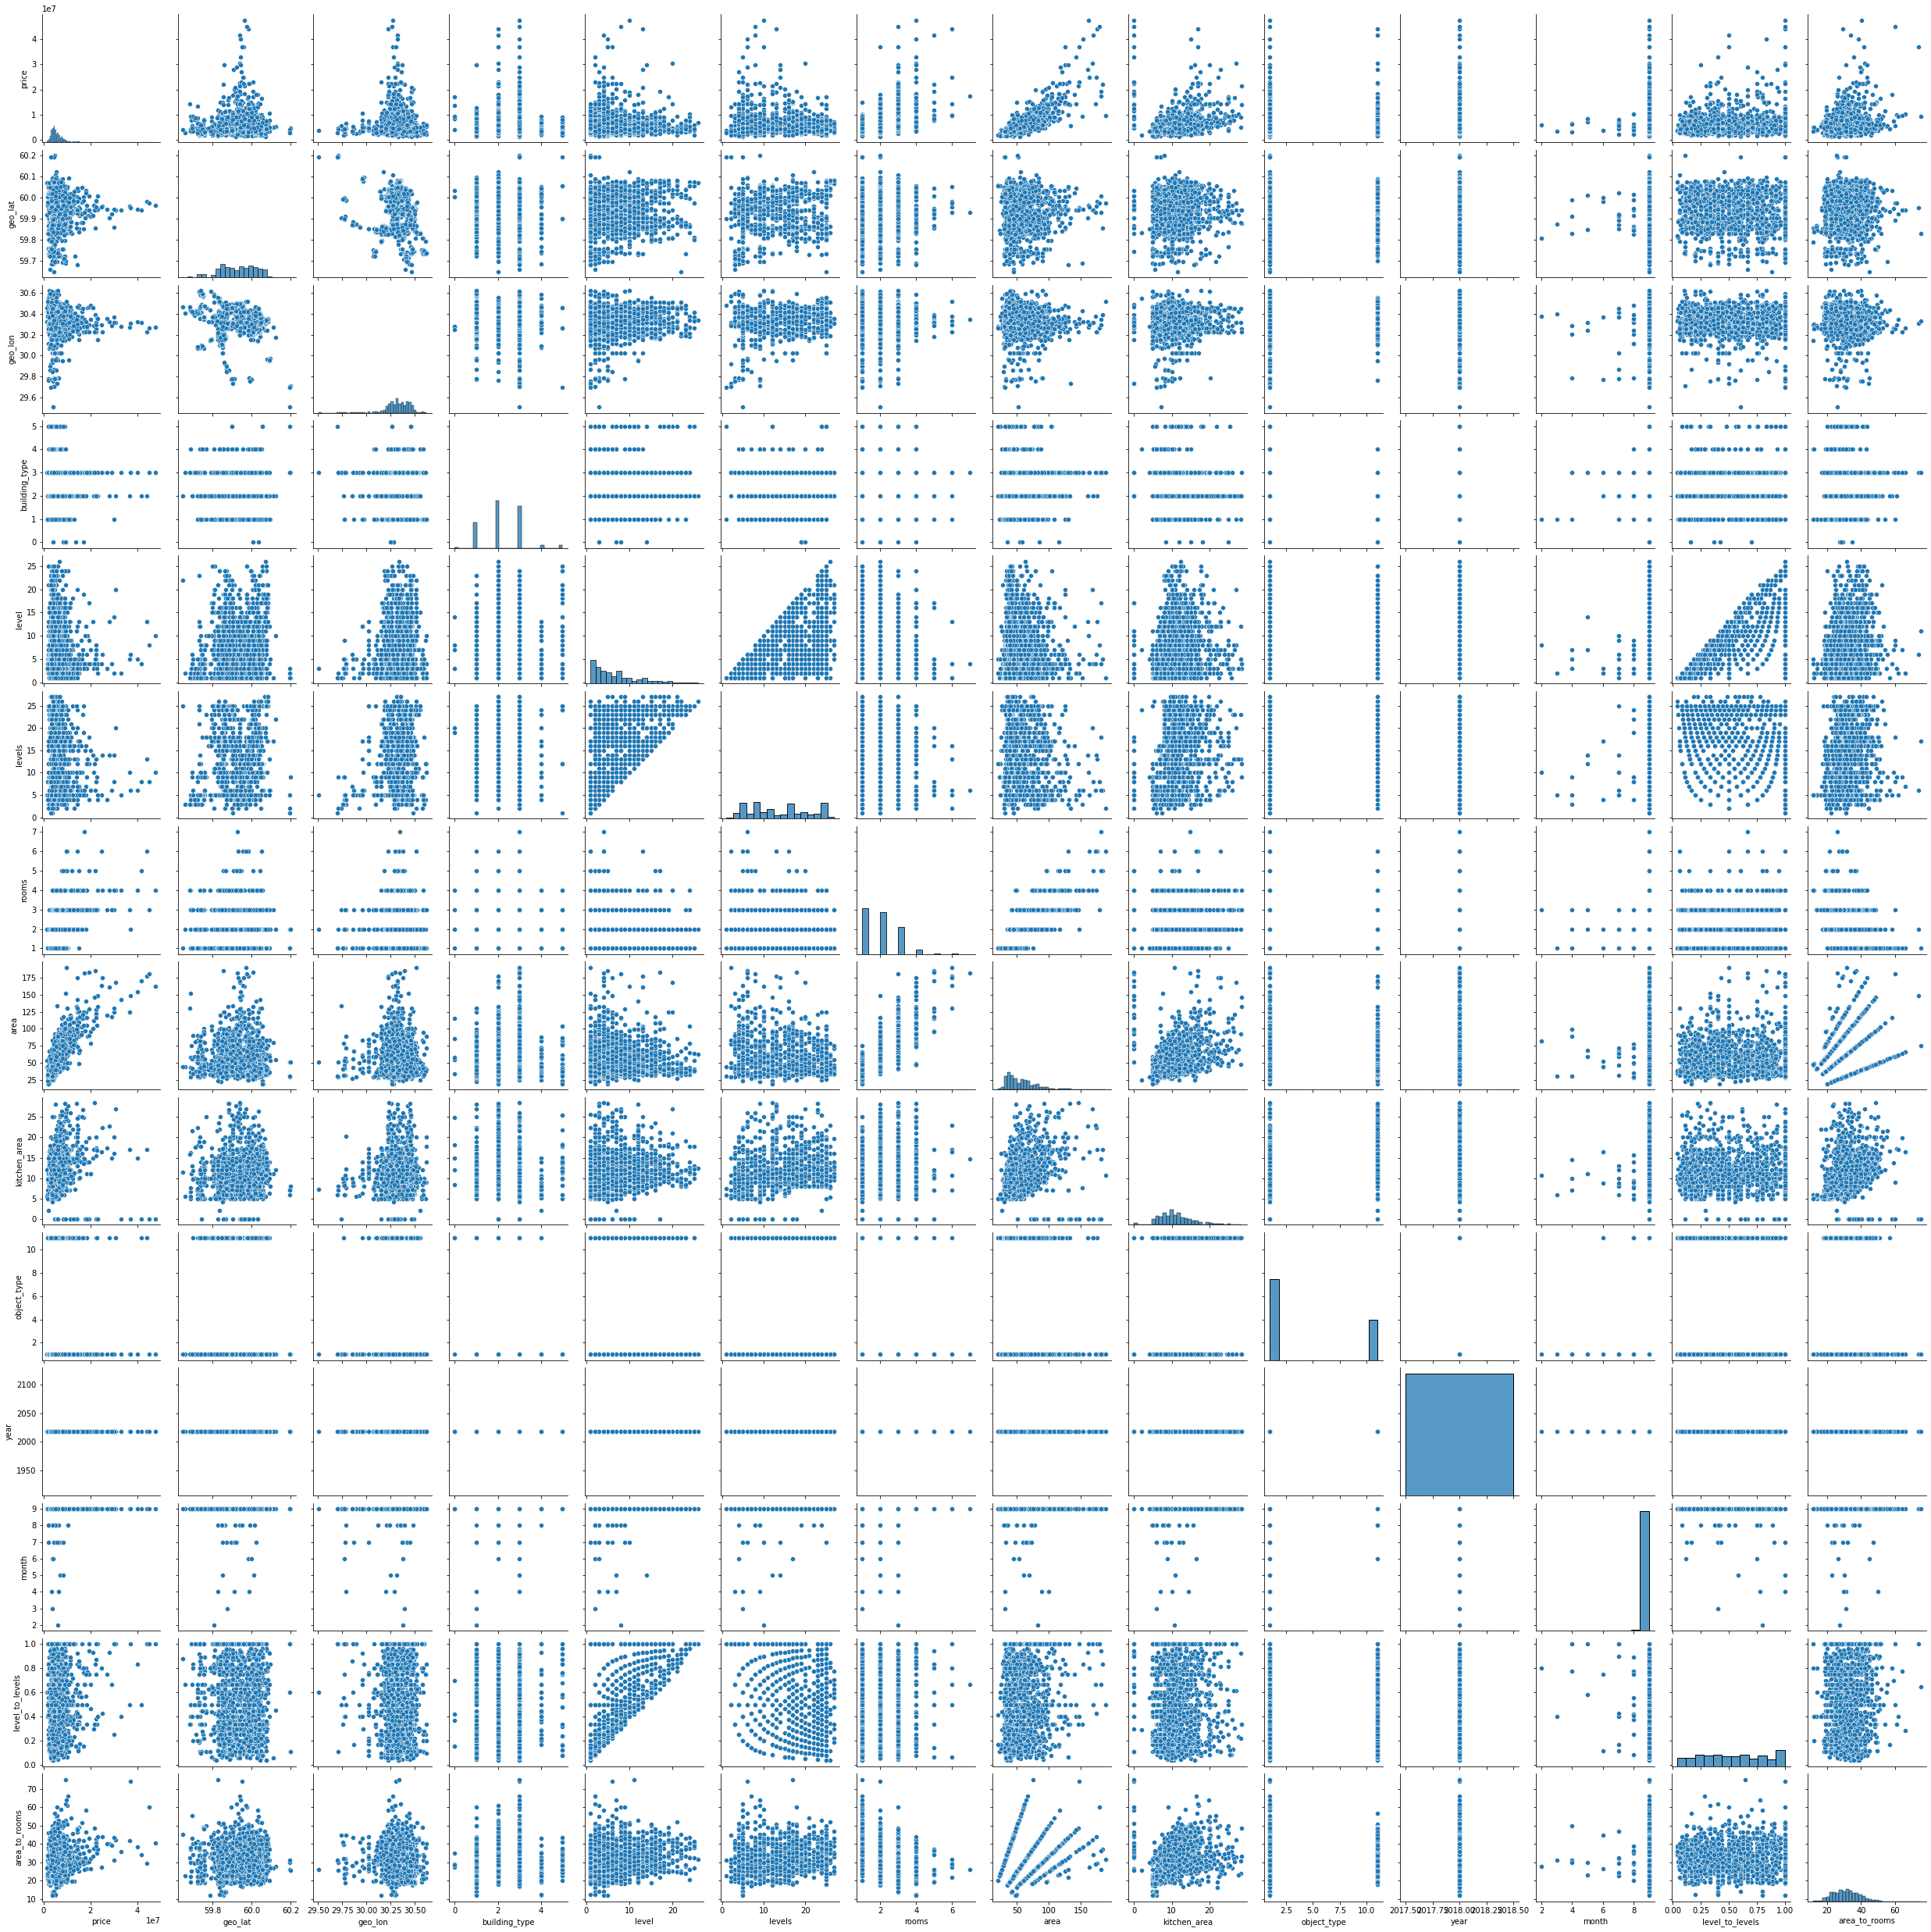

In [19]:
sns.pairplot(df)

Histogram plot

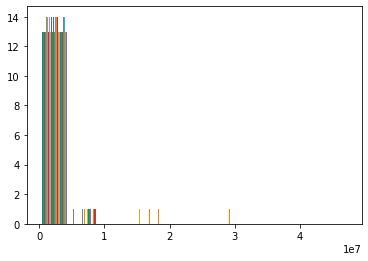

In [20]:
plt.hist(df)
plt.show()